In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(84).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(44).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(245).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/6.jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(238).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(196).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(108).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(310).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image (5).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(186).jpg
/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/image(29).jpg
/kaggle/input/classification-of-br

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, r2_score, mean_absolute_error, f1_score
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
X = []
Y = []
classes = {'no_tumor': 0, 'pituitary_tumor': 1}
dataset_path = '/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1'

for cls in classes:
    pth = os.path.join(dataset_path, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (200, 200))  # Resize to 200x200
        X.append(img)
        Y.append(classes[cls])


X = np.array(X)
Y = np.array(Y)

# Print the shapes to verify the conversion
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Shuffle the data
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
Y = Y[randomize]


X shape: (1226, 200, 200)
Y shape: (1226,)


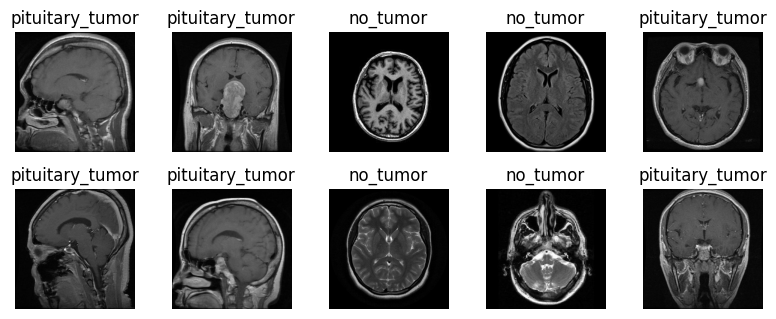

In [4]:
def plot_sample_images(images, labels, class_names, grid_size=(5, 5)):
    plt.figure(figsize=(8, 8))
    for i in range(min(len(images), grid_size[0] * grid_size[1])):
        plt.subplot(grid_size[0], grid_size[1], i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# You can adjust the number of sample images to display
num_sample_images = 10

# Get sample images and labels
sample_images = X[:num_sample_images]
sample_labels = Y[:num_sample_images]
class_names = ['no_tumor', 'pituitary_tumor']  # Replace with your actual class names

# Plot sample images with labels
plot_sample_images(sample_images, sample_labels, class_names)

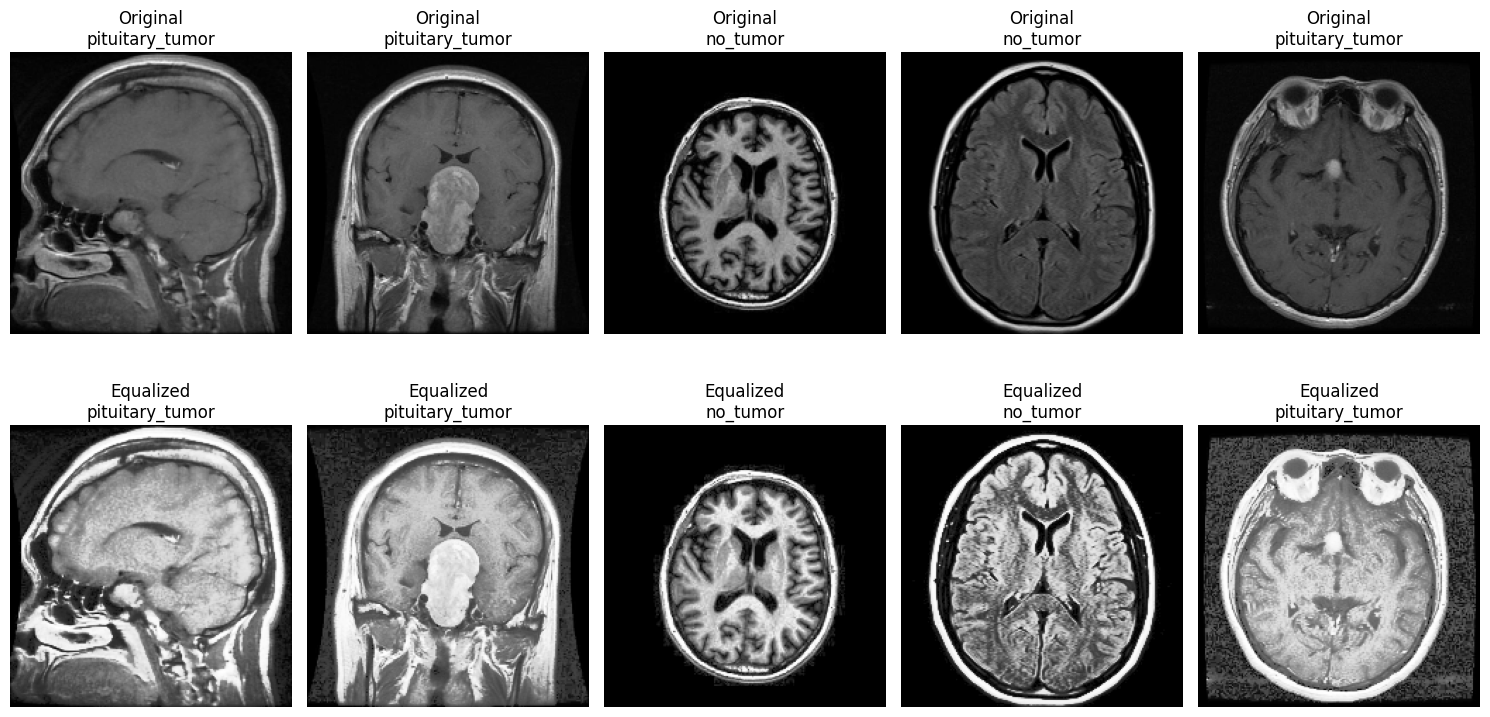

In [5]:
# Define a function to apply histogram equalization
def apply_histogram_equalization(img):
    # Apply histogram equalization
    equalized_img = cv2.equalizeHist(img)
    return equalized_img

# Define the number of sample images to display
num_sample_images = 5

# Get sample images and labels
sample_images = X[:num_sample_images]
sample_labels = Y[:num_sample_images]
class_names = ['no_tumor', 'pituitary_tumor']  # Replace with your actual class names

# Display the original and equalized images
plt.figure(figsize=(15, 8))

for i in range(num_sample_images):
    plt.subplot(2, num_sample_images, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'Original\n{class_names[sample_labels[i]]}')
    plt.axis('off')

    plt.subplot(2, num_sample_images, num_sample_images + i + 1)
    equalized_img = apply_histogram_equalization(sample_images[i])
    plt.imshow(equalized_img, cmap='gray')
    plt.title(f'Equalized\n{class_names[sample_labels[i]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
# Split the dataset into 70% training and 30% temp (testing + validation)
xtrain, xtemp, ytrain, ytemp = train_test_split(X, Y, random_state=10, test_size=0.3)

# Split the temp dataset into 50% testing and 50% validation
xtest, xval, ytest, yval = train_test_split(xtemp, ytemp, test_size=0.5, random_state=10)


In [7]:
# Normalize pixel values
xtrain = xtrain / 255.0
xtest = xtest / 255.0
xval = xval / 255.0

In [8]:
from sklearn.model_selection import ParameterGrid

In [9]:
# Define hyperparameter grid for manual tuning
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'kernel_size': [(3, 3), (5, 5)],
    'pool_size': [(2, 2), (3, 3)]
}

best_accuracy = 0.0
best_model = None
best_params = {}

# Iterate through hyperparameter combinations
for params in ParameterGrid(param_grid):
    optimizer = params['optimizer']
    kernel_size = params['kernel_size']
    pool_size = params['pool_size']

    # Build the CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size, activation='relu', input_shape=(200, 200, 1)))
    model.add(layers.MaxPooling2D(pool_size))
    model.add(layers.Conv2D(64, kernel_size, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size))
    model.add(layers.Conv2D(128, kernel_size, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # Two classes: 'no_tumor' and 'pituitary_tumor'

    # Compile the model with current hyperparameters
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the CNN model
    train = model.fit(xtrain, ytrain, epochs=10, validation_data=(xval, yval), verbose=0)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(xtest, ytest, verbose=0)

    # Check if current model is the best so far
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model = model
        best_params = params

model = best_model

In [10]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 196, 196, 32)      832       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 98, 98, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 94, 94, 64)        51264     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 43, 43, 128)       204928    
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 21, 21, 128)      

In [11]:
model.save('brain-tumor-detection-final.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# # Evaluate the model
val_loss, val_acc = model.evaluate(xval, yval, verbose=2)
print("\nTest accuracy:", val_acc)


6/6 - 0s - loss: 0.1817 - accuracy: 0.9728 - 68ms/epoch - 11ms/step

Test accuracy: 0.9728260636329651


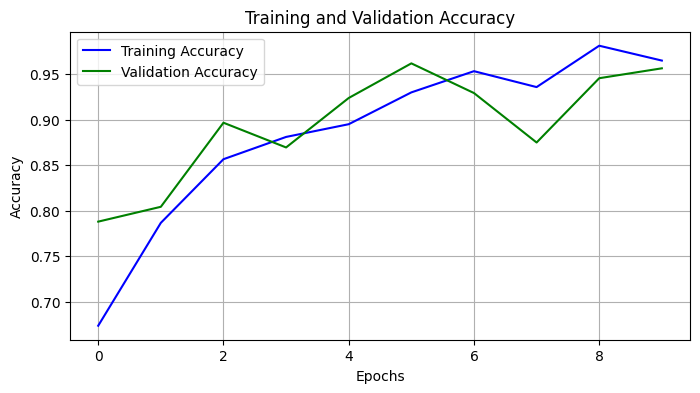

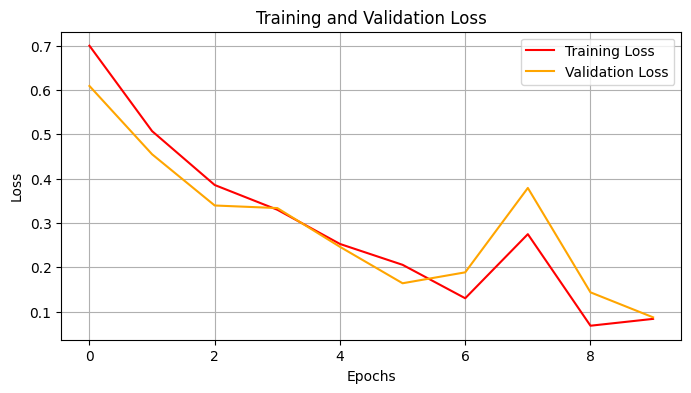

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(train.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(train.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(train.history['loss'], label='Training Loss', color='red')
plt.plot(train.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [14]:
# Make predictions and convert to class labels (0 or 1)
pred_probs = model.predict(xtest)
pred_labels = np.argmax(pred_probs, axis=1)
train_pred_labels = model.predict(xtrain)
train_pred_labels = np.argmax(train_pred_labels, axis=1)


27/27 [==============================] - 0s 7ms/step


In [15]:
# Calculate metrics
accuracy = accuracy_score(ytest, pred_labels)
precision = precision_score(ytest, pred_labels)
mae = mean_absolute_error(ytest, pred_labels)
r2 = r2_score(ytest, pred_labels)
f1 = f1_score(ytest, pred_labels)

In [16]:
# Print the calculated metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Mean Absolute Error:", mae)
print("R-sqore:", r2)
print("F1 Score:", f1)


Accuracy: 0.9945652173913043
Precision: 1.0
Mean Absolute Error: 0.005434782608695652
R-sqore: 0.9745821246028457
F1 Score: 0.9960474308300395


<Figure size 400x400 with 0 Axes>

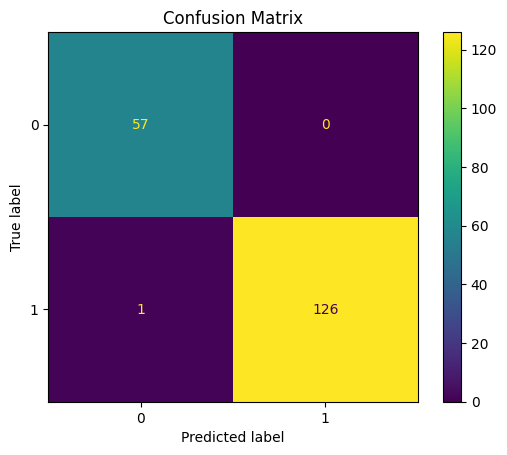

In [17]:
# Getiing Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(ytest, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(4, 4))
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

<Figure size 400x400 with 0 Axes>

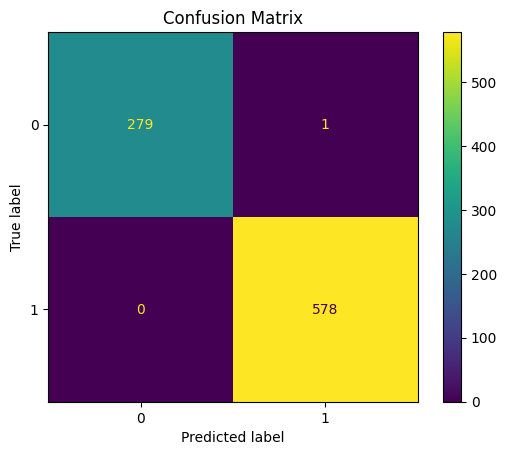

In [18]:
# Getiing Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(ytrain, train_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(4, 4))
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print("Train Classifier Report \n")
from sklearn.metrics import classification_report, accuracy_score

# Assuming you have predicted labels 'y_pred' and true labels 'y_true'

# Calculate accuracy
accuracy = accuracy_score(ytrain, train_pred_labels)

# Get a classification report
report = classification_report(ytrain, train_pred_labels)

# Print accuracy and the classification report
print("Accuracy:", accuracy)
print(report)


print("\nTest Classifier Report\n")

# Calculate accuracy
accuracy = accuracy_score(ytest, pred_labels)

# Get a classification report
report = classification_report(ytest, pred_labels)

# Print accuracy and the classification report
print("Accuracy:", accuracy)
print(report)

Train Classifier Report 

Accuracy: 0.9988344988344988
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       280
           1       1.00      1.00      1.00       578

    accuracy                           1.00       858
   macro avg       1.00      1.00      1.00       858
weighted avg       1.00      1.00      1.00       858


Test Classifier Report

Accuracy: 0.9945652173913043
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      0.99      1.00       127

    accuracy                           0.99       184
   macro avg       0.99      1.00      0.99       184
weighted avg       0.99      0.99      0.99       184



In [20]:
new_image_path = '/kaggle/input/classification-of-brain-tumor-dataset/brain_tumor1/no_tumor/1.jpg'

# Load and preprocess the new image
new_img = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(new_img, (200, 200))
new_img = np.array(new_img) / 255.0  # Normalize pixel values

# Reshape the image to match the input shape of the model
new_img = new_img.reshape((1, 200, 200, 1))

# Use the trained model to predict the class
prediction = model.predict(new_img)
predicted_class = np.argmax(prediction)

# Map the predicted class to the corresponding label
class_labels = {v: k for k, v in classes.items()}
predicted_label = class_labels[predicted_class]

# Print the result
print(f"The predicted class for the image is: {predicted_label}")

1/1 [==============================] - 0s 122ms/step
The predicted class for the image is: no_tumor
